In [17]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('../data/customer_base + drive score.csv')
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861 entries, 0 to 4860
Data columns (total 108 columns):
 #    Column                                                 Non-Null Count  Dtype  
---   ------                                                 --------------  -----  
 0    seasoning_3month_incident_Ind                          4861 non-null   int64  
 1    Subscriber Id                                          4861 non-null   object 
 2    Creation Date                                          4861 non-null   object 
 3    Month of Creation Date                                 4861 non-null   float64
 4    Gender First Name Estimated                            4861 non-null   object 
 5    sp_counts_customer_level                               615 non-null    float64
 6    mp_counts_customer_level                               615 non-null    float64
 7    1st_sp_date_customer_level                             191 non-null    object 
 8    1st_mp_date_customer_level          

## Imbalance learn

In [ ]:
## imbalance learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import sklearn modules
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector as selector

# Import imblearn pipeline and oversampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


# Read the data and create the new column
data = pd.read_csv('../data/customer_base + drive score.csv')
data['vehivel_request_fufillment'] = data['Vehicle Requests Make Model List'] == data['Most Recent Vehicle Request Assigned Make Model']

# Drop unused columns
columns_to_drop = ['Subscriber Id', 'Most Recent Invoice Order Id', 'First Invoice Id', 'Most Recent Invoice Id', 'First Invoice Order Id', # id
'1st_incident', '1st_mp_date_customer_level', '1st_sp_date_customer_level', 'mp_counts_customer_level', 'sp_counts_customer_level', # target related
'Creation Date', 'First Invoice Date', 'Most Recent Invoice Date', 'Driving Record Updated At', 'Driving Record Creation Time', # dates
'Vehicle Requests Make Model List', 'Most Recent Vehicle Request Requested Make Model', 'Most Recent Vehicle Request Assigned Make Model', 'First Order Requested Make', # vehicle
'days_run_in_accident', 'Credit Score Approval Status',
'License State',
'Most Recent Promo Code Used'] # others

Target = 'seasoning_3month_incident_Ind'
y = data[Target]
X = data.drop(columns=[Target] + columns_to_drop, axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define columns
miles_columns = ['Total Miles Driven', 'Total Miles Driven Monthly', 'Total Miles Driven Pre Monthly', 'Miles per Week', 'Miles per Month']

numerical_columns_selector = selector(dtype_include=np.number)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

# Exclude miles_columns from these groups
numerical_columns = list(set(numerical_columns) - set(miles_columns))
categorical_columns = list(set(categorical_columns) - set(miles_columns))

# Preprocessor for numeric columns (excluding miles)
numeric_transformer = Pipeline(
steps=[
("imputer_num", SimpleImputer(strategy="median")),
("scaler", StandardScaler())
]
)

# Preprocessor for miles columns
miles_transformer = Pipeline(
steps=[
("imputer_num", SimpleImputer(strategy="constant", fill_value=0)),
("scaler", StandardScaler())
]
)

# Preprocessor for categorical columns
categorical_transformer = Pipeline(
steps=[
("imputer_cat", SimpleImputer(strategy="constant", fill_value='missing')),
("encode", OrdinalEncoder())
]
)

# Combine preprocessors using ColumnTransformer
preprocessor = ColumnTransformer(
transformers=[
("num", numeric_transformer, list(numerical_columns)),
("miles", miles_transformer, list(miles_columns)),
("cat", categorical_transformer, list(categorical_columns)),
]
)

# Create the pipeline with preprocessing, oversampling, and the classifier.
# Note: We use the imblearn.pipeline.Pipeline so that the oversampling step is integrated.
steps = [
('preprocess', preprocessor),
('oversample', RandomOverSampler(random_state=42)), # oversample rare class
# If you prefer SMOTE, you can replace the above with:
# ('oversample', SMOTE(random_state=42)),
('rf', RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=20, min_samples_leaf=1, min_samples_split=2))
]

model = ImbPipeline(steps)

# Fit the pipeline on the training data
model.fit(X_train, y_train)

# Evaluate on the test set
print("Test set score:", model.score(X_test, y_test))


Test set score: 0.9602467443454421


In [82]:

from sklearn.metrics import classification_report
print('------------------- Confusion Matric -------------------')
target_names = ['0', '1']
y_test_pred= model.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))

------------------- Confusion Matric -------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1409
           1       0.00      0.00      0.00        50

    accuracy                           0.96      1459
   macro avg       0.48      0.50      0.49      1459
weighted avg       0.93      0.96      0.95      1459



## Sklearn

In [ ]:
data = pd.read_csv('../data/incident_data_all.csv')
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5948 entries, 0 to 5947
Data columns (total 123 columns):
 #    Column                                                 Dtype  
---   ------                                                 -----  
 0    days_run_in_accident                                   float64
 1    days_run_in_mp                                         float64
 2    1st_sp_date_customer_level                             object 
 3    1st_mp_date_customer_level                             object 
 4    1st_incident                                           object 
 5    seasoning_3month_incident_Ind                          int64  
 6    seasoning_3month_mp_Ind                                int64  
 7    Subscriber Id                                          object 
 8    Creation Date                                          object 
 9    Month of Creation Date                                 float64
 10   Gender First Name Estimated                            obj

<Axes: ylabel='Frequency'>

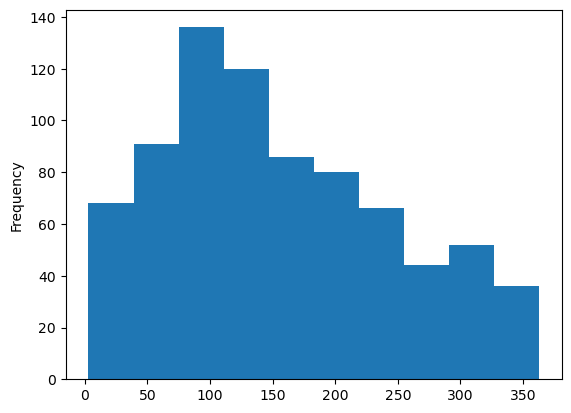

In [92]:
data['days_run_in_accident'].plot(kind='hist')

## all features

## dropped features

Feature impartance:
---------------------------------------------------------
                                                        0
num__score_mean                                  0.059384
num__braking_per_1000miles                       0.048940
num__cornering_per_1000miles                     0.048566
num__score_std                                   0.048346
num__speeding_per_1000miles                      0.038787
num__Percent Active                              0.031136
num__Total Paid Vehicle Fee Invoices             0.030927
num__Num Delinquent Receipts Resolved            0.029841
num__Month of Creation Date                      0.029798
num__Total Invoices With Initial Payment Failed  0.027226
num__Average Initial Failure Rate                0.027003
num__Days From First Pickup to Delinquent        0.026889
num__drivingEvent_per_1000miles                  0.024499
num__Total Uncollected Revenue                   0.019157
num__population                                  0.0

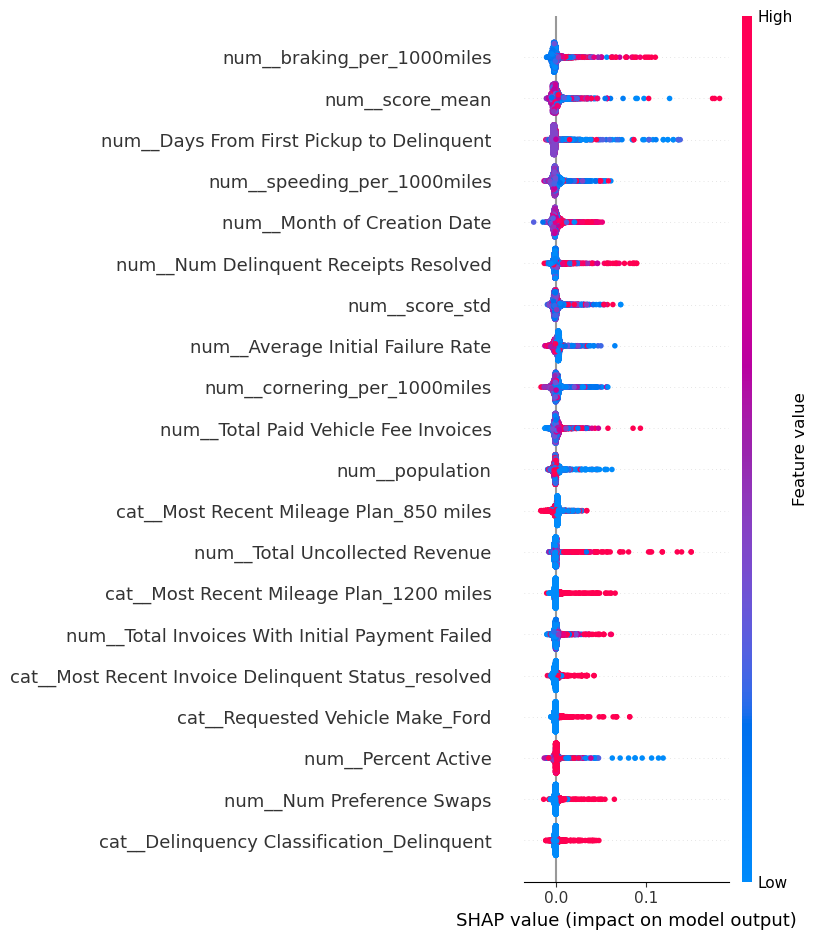

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector as selector
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


## functions
def month_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

# data = pd.read_csv('../data/customer_base + drive score.csv')
data = pd.read_csv('../data/incident_data_all.csv')
data['vehivel_request_fufillment'] = data['Vehicle Requests Make Model List'] == data['Most Recent Vehicle Request Assigned Make Model']
data['season'] = data['Month of Creation Date'].map(month_to_season)
data['seasoning_6month_incident_Ind'] = data['days_run_in_accident'].map(lambda x: 1 if x < 180 else 0)
# data['score_basket'] = data['score_mean'].map(lambda x: 'poor' if x < 0.6 else 'good')

columns_to_drop = ['Subscriber Id', 'Most Recent Invoice Order Id', 'First Invoice Id', 'Most Recent Invoice Id', 'First Invoice Order Id', 'Subui Creation Date', ## id
                   '1st_incident', '1st_mp_date_customer_level', '1st_sp_date_customer_level', 'mp_counts_customer_level',  'sp_counts_customer_level',  # target relatd
                   'Creation Date', 'First Invoice Date', 'Most Recent Invoice Date', 'Driving Record Updated At', 'Driving Record Creation Time', 'Day of 1st_incident', # date and time
                   'Vehicle Requests Make Model List', 'Most Recent Vehicle Request Requested Make Model', 'Most Recent Vehicle Request Assigned Make Model',  'First Order Requested Make', # vehicle
                   'days_run_in_accident',  'Days With Vehicle', 'Days Since First Order', 'Active Weeks', 'days_run_in_mp', # days related to miles
                   'Total Tax Amount', 'Total Revenue', 'Total Collected Revenue', 'Total Collected Vehicle Amount', 'Total Receipts', 'Total Paid Invoices', 'Total Collected Mileage Amount', 'Total Collected Fee Amount', 'Total Paid Mileage Invoices', # revenue realted features
                    'Credit Score Approval Status', 
                   'License State',
                   'Most Recent Promo Code Used', # others
                   'Total Miles Driven Monthly', 'Total Miles Driven Pre Monthly', 'Miles per Week', 'Total Miles Driven', # miles
                   'seasoning_3month_mp_Ind',  'seasoning_6month_incident_Ind',
                   'Miles per Month', 'Miles Driven', # miles driven
                'score_q1', 'score_q2', 'score_q3',
                   ]
Target = 'seasoning_3month_incident_Ind'
y = data[Target]
X = data.drop(columns=[Target]+columns_to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

miles_columns = []

numerical_columns_selector = selector(dtype_include=np.number)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

# update num and cat columns
numerical_columns = list(set(numerical_columns) - set(miles_columns))
categorical_columns = list(set(categorical_columns) - set(miles_columns))

# preprocesser
numeric_transformer = Pipeline(
    steps=[("imputer_num", 
            SimpleImputer(strategy="median")), 
            # SimpleImputer(strategy="constant", fill_value=0)), 
            ("scaler", StandardScaler())]
)

miles_transformer = Pipeline(
    steps=[("imputer_num", 
            SimpleImputer(strategy="constant", fill_value=0)), 
            ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer_cat", SimpleImputer(strategy="constant", fill_value='missing')), 
           ("encode", OneHotEncoder(handle_unknown='ignore',drop='if_binary'))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, list(numerical_columns)),
        ("miles", miles_transformer, list(miles_columns)),
        ("cat", categorical_transformer, list(categorical_columns)),
    ]
)

steps = [('preprocess', preprocessor),
        #  ('oversample', RandomOverSampler(random_state=42)),
         ('rf', RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=20, min_samples_leaf=1, min_samples_split=2))]

model = Pipeline(steps)
model_rf = model.fit(X_train, y_train)

## feature impartant
# feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
# feature_importances.sort_values(by=0, ascending=False).head(20)
feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
print('Feature impartance:')
print('---------------------------------------------------------')
print(feature_importances.sort_values(by=0, ascending=False).head(20))
print('\n')

## confusion matrix
from sklearn.metrics import roc_auc_score
print('---------- ROC_AUC_score-------------')
print('Training data:', roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]))
print('Test data:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))
print('\n')

from sklearn.metrics import matthews_corrcoef
print('---------- MCC_score-------------')
print('Training data:', matthews_corrcoef(y_train, model_rf.predict(X_train)))
print('Test data:', matthews_corrcoef(y_test, model_rf.predict(X_test)))

from sklearn.metrics import classification_report
print('------------------- Confusion Matric -------------------')
target_names = ['0', '1']
y_test_pred= model_rf.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))
print('\n')


## shap
import shap
X_transformed = model_rf.named_steps['preprocess'].transform(X_train)
clf = model_rf.named_steps["rf"]
columns = model_rf.named_steps['preprocess'].get_feature_names_out()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_transformed)
shap.summary_plot(shap_values[:,:,1], X_transformed, feature_names=columns)

In [108]:
len(numerical_columns) + len(categorical_columns)

74

In [45]:
# from sklearn.metrics import roc_auc_score

# print('---------- ROC_AUC_score-------------')
# print('Training data:', roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]))
# print('Test data:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))

# from sklearn.metrics import classification_report
# print('------------------- Confusion Matric -------------------')
# target_names = ['0', '1']
# y_test_pred= model_rf.predict(X_test)
# print(classification_report(y_test, y_test_pred, target_names=target_names))

In [48]:
# import shap
# X_transformed = model_rf.named_steps['preprocess'].transform(X_train)
# clf = model_rf.named_steps["rf"]
# columns = model_rf.named_steps['preprocess'].get_feature_names_out()
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(X_transformed)
# shap.summary_plot(shap_values[:,:,1], X_transformed, feature_names=columns)

## sp vs mp

In [80]:
data = pd.read_csv('../data/incident_sp_vs_mp.csv')
data['Mileage Plan at Order'].value_counts()

Mileage Plan at Order
850 miles        124
Pay as you go     70
1200 miles        57
500 miles         26
Pre-monthly        3
2000 miles         1
Name: count, dtype: int64

Feature impartance:
---------------------------------------------------------
                                                        0
num__score_mean                                  0.045178
num__score_std                                   0.043747
num__braking_per_1000miles                       0.038445
num__Average Initial Failure Rate                0.035624
num__speeding_per_1000miles                      0.034662
num__Month of Creation Date                      0.033652
num__drivingEvent_per_1000miles                  0.031693
num__score_q2                                    0.031572
num__cornering_per_1000miles                     0.031477
num__Total Paid Vehicle Fee Invoices             0.031311
num__score_q1                                    0.030009
num__score_q3                                    0.028861
num__Percent Active                              0.026346
num__Num Delinquent Receipts Resolved            0.026345
num__Total Invoices With Initial Payment Failed  0.0

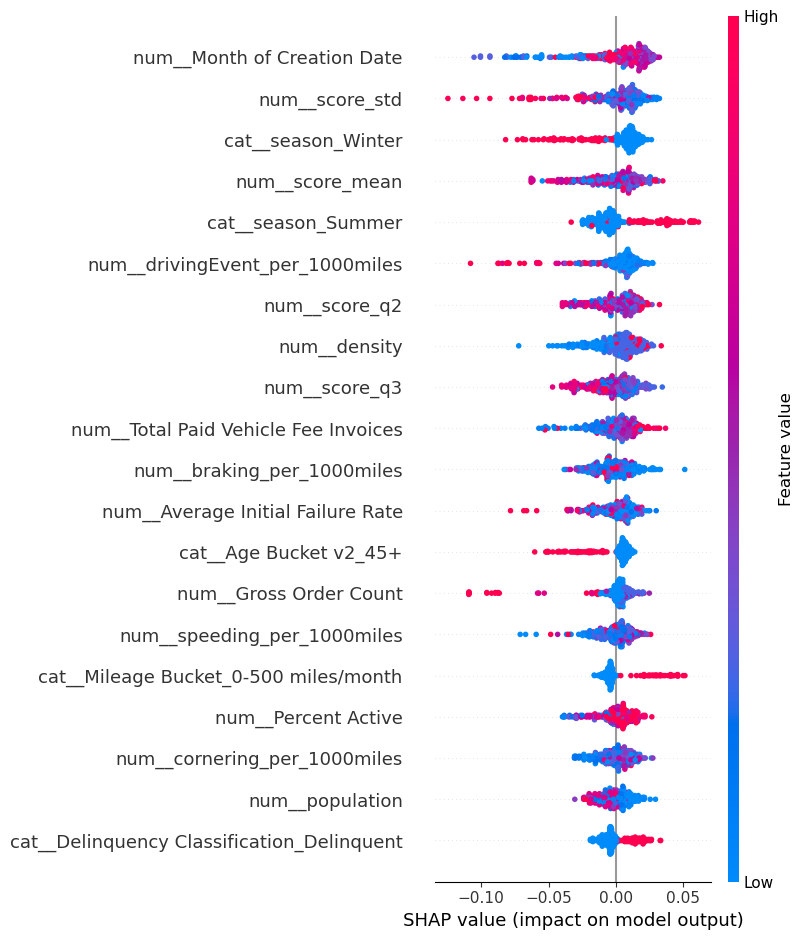

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector as selector
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


## functions
def month_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

# data = pd.read_csv('../data/customer_base + drive score.csv')
data = pd.read_csv('../data/incident_data_all.csv')

data['vehivel_request_fufillment'] = data['Vehicle Requests Make Model List'] == data['Most Recent Vehicle Request Assigned Make Model']
data['season'] = data['Month of Creation Date'].map(month_to_season)
data['seasoning_6month_incident_Ind'] = data['days_run_in_accident'].map(lambda x: 1 if x < 180 else 0)
data['seasoning_6month_mp_Ind'] = data['days_run_in_mp'].map(lambda x: 1 if x < 180 else 0)

data = data[data['seasoning_6month_incident_Ind'] == 1] # filter out all incident record

columns_to_drop = ['Subscriber Id', 'Most Recent Invoice Order Id', 'First Invoice Id', 'Most Recent Invoice Id', 'First Invoice Order Id', 'Subui Creation Date', ## id
                   '1st_incident', '1st_mp_date_customer_level', '1st_sp_date_customer_level', 'mp_counts_customer_level',  'sp_counts_customer_level',  # target relatd
                   'Creation Date', 'First Invoice Date', 'Most Recent Invoice Date', 'Driving Record Updated At', 'Driving Record Creation Time', 'Day of 1st_incident', # date and time
                   'Vehicle Requests Make Model List', 'Most Recent Vehicle Request Requested Make Model', 'Most Recent Vehicle Request Assigned Make Model',  'First Order Requested Make', # vehicle
                   'days_run_in_accident',  'Days With Vehicle', 'Days Since First Order', 'Active Weeks', 'days_run_in_mp', # days related to miles
                   'Total Tax Amount', 'Total Revenue', 'Total Collected Revenue', 'Total Collected Vehicle Amount', 'Total Receipts', 'Total Paid Invoices', 'Total Collected Mileage Amount', 'Total Collected Fee Amount', 'Total Paid Mileage Invoices', # revenue realted features
                    'Credit Score Approval Status', 
                   'License State',
                   'Most Recent Promo Code Used', # others
                   'Total Miles Driven Monthly', 'Total Miles Driven Pre Monthly', 'Miles per Week', 'Total Miles Driven', # miles
                   'seasoning_3month_mp_Ind', 'seasoning_3month_incident_Ind', 
                   'Miles per Month', 'Miles Driven', # miles driven
                   ]
Target = 'seasoning_6month_mp_Ind'
y = data[Target]
X = data.drop(columns=[Target]+columns_to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

miles_columns = []

numerical_columns_selector = selector(dtype_include=np.number)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

# update num and cat columns
numerical_columns = list(set(numerical_columns) - set(miles_columns))
categorical_columns = list(set(categorical_columns) - set(miles_columns))

# preprocesser
numeric_transformer = Pipeline(
    steps=[("imputer_num", 
            SimpleImputer(strategy="median")), 
            # SimpleImputer(strategy="constant", fill_value=0)), 
            ("scaler", StandardScaler())]
)

miles_transformer = Pipeline(
    steps=[("imputer_num", 
            SimpleImputer(strategy="constant", fill_value=0)), 
            ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer_cat", SimpleImputer(strategy="constant", fill_value='missing')), 
           ("encode", OneHotEncoder(handle_unknown='ignore'))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, list(numerical_columns)),
        ("miles", miles_transformer, list(miles_columns)),
        ("cat", categorical_transformer, list(categorical_columns)),
    ]
)

steps = [('preprocess', preprocessor),
        #  ('oversample', RandomOverSampler(random_state=42)),
         ('rf', RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=20, min_samples_leaf=1, min_samples_split=2))]

model = Pipeline(steps)
model_rf = model.fit(X_train, y_train)

## feature impartant
# feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
# feature_importances.sort_values(by=0, ascending=False).head(20)
feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
print('Feature impartance:')
print('---------------------------------------------------------')
print(feature_importances.sort_values(by=0, ascending=False).head(20))
print('\n')

## confusion matrix
from sklearn.metrics import roc_auc_score

print('---------- ROC_AUC_score-------------')
print('Training data:', roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]))
print('Test data:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))

from sklearn.metrics import classification_report
print('------------------- Confusion Matric -------------------')
target_names = ['0', '1']
y_test_pred= model_rf.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))
print('\n')


## shap
import shap
X_transformed = model_rf.named_steps['preprocess'].transform(X_train)
clf = model_rf.named_steps["rf"]
columns = model_rf.named_steps['preprocess'].get_feature_names_out()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_transformed)
shap.summary_plot(shap_values[:,:,1], X_transformed, feature_names=columns)